In [1]:
# 모듈 가져오기
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 데이터 불러오기
credit_data = pd.read_csv('./Data/german_credit_new.csv')

## 데이터 확인 및 탐색하기

In [3]:
# 데이터 shape 확인하기
credit_data.shape

(1000, 21)

In [4]:
# 데이터 컬럼 및 타입 확인하기
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [5]:
# object와 ,int 타입 데이터가 존재
# 컬럼명에 공백이 들어가 있다. 공백 -> "_"
credit_data.columns = credit_data.columns.str.replace(' ', '_')
# 다른방법으로는
# credit_data.rename(columns = lambda x : x.replace(' ', '_'))

In [6]:
# 종속변수 확인 =>: class
credit_data['class'].unique()

array([1, 2], dtype=int64)

In [7]:
# 종속변수가 1, 2로 되어있다. -> 0, 1로 변환시키자
credit_data['class'] = credit_data['class'] - 1

In [8]:
# 종속변수 확인
credit_data['class'].unique()

array([0, 1], dtype=int64)

In [9]:
# 데이터 확인 - head()
credit_data.head()

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account/bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_/_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [10]:
# 신용 데이터
# 종속변수
# 0 : 신용양호
# 1 : 신용불량자

## 독립변수에 관한 각 변수의 예측 능력을 알아보기 위해 정보가치를 계산해본다.
<h2> 정보가치 = $ ln(\frac{good}{bad})(good - bad)  $ </h2>
<h2> 증거 가중값 = $ ln(\frac{good}{bad})$</h2>

In [11]:
# 임의의 명목형 변수에 대해서 groupby -> class에 대해서만 count, sum
# 왜냐하면, class는 0과 1의 이진화변수이기 때문에 sum의 경우 1인 경우의 숫자를 알 수 있다.
dataf = credit_data.groupby(['Credit_history'])['class'].agg(['count', 'sum'])
dataf.columns = ['Total', 'bad'] # class가 1인 경우가 신용 불량자 : bad
dataf['good'] = dataf["Total"] - dataf['bad']
dataf['bad_per'] = dataf['bad'] / dataf['bad'].sum()
dataf['good_per'] = dataf['good'] / dataf['good'].sum()
dataf['I_V'] = np.log(dataf['good_per']/dataf['bad_per']) * (dataf['good_per'] - dataf['bad_per'])

In [12]:
# 데이터 확인
dataf

,Total,bad,good,bad_per,good_per,I_V
Credit_history,,,,,,
A30,40,25,15,0.083333,0.021429,0.084074
A31,49,28,21,0.093333,0.030000,0.071882
A32,530,169,361,0.563333,0.515714,0.004206
A33,88,28,60,0.093333,0.085714,0.000649
A34,293,50,243,0.166667,0.347143,0.132423


In [13]:
# 임의의 연속형 변수에 대해서는 범주화가 필요하다. => 범주화를 통해서 명목화 시킬 수 있다.
# 로지스틱 회귀는 기본적으로 분류를 위한 모델이기 때문에 범주화가 필수
# 범주화 시, 내림차순으로 정렬하는것이 매우 중요하다.
tmp_df = credit_data[:]
tmp_df['bin_var'] = pd.qcut(credit_data['Duration_in_month'].rank(method = 'first'),10)
dataf = tmp_df.groupby(['bin_var'])['class'].agg(['count', 'sum'])
dataf.columns = ['Total', 'bad'] # class가 1인 경우가 신용 불량자 : bad
dataf['good'] = dataf["Total"] - dataf['bad']
dataf['bad_per'] = dataf['bad'] / dataf['bad'].sum()
dataf['good_per'] = dataf['good'] / dataf['good'].sum()
dataf['I_V'] = np.log(dataf['good_per']/dataf['bad_per']) * (dataf['good_per'] - dataf['bad_per'])

<ipython-input-13-b8fa552e85ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['bin_var'] = pd.qcut(credit_data['Duration_in_month'].rank(method = 'first'),10)


In [14]:
# 데이터 확인
dataf

,Total,bad,good,bad_per,good_per,I_V
bin_var,,,,,,
"(0.999, 100.9]",100,11,89,0.036667,0.127143,0.112502
"(100.9, 200.8]",100,20,80,0.066667,0.114286,0.025667
"(200.8, 300.7]",100,27,73,0.090000,0.104286,0.002105
"(300.7, 400.6]",100,25,75,0.083333,0.107143,0.005984
"(400.6, 500.5]",100,26,74,0.086667,0.105714,0.003784
"(500.5, 600.4]",100,38,62,0.126667,0.088571,0.013629
"(600.4, 700.3]",100,32,68,0.106667,0.097143,0.000891
"(700.3, 800.2]",100,31,69,0.103333,0.098571,0.000225
"(800.2, 900.1]",100,42,58,0.140000,0.082857,0.029973


In [15]:
# 모든 독립변수에 대해서 자동화를 위해 함수를 만든다.
def IV_calc(data, var):
    if data[var].dtypes == 'object':
        dataf = credit_data.groupby([var])['class'].agg(['count', 'sum'])
        dataf.columns = ['Total', 'bad'] # class가 1인 경우가 신용 불량자 : bad
        dataf['good'] = dataf["Total"] - dataf['bad']
        dataf['bad_per'] = dataf['bad'] / dataf['bad'].sum()
        dataf['good_per'] = dataf['good'] / dataf['good'].sum()
        dataf['I_V'] = np.log(dataf['good_per']/dataf['bad_per']) * (dataf['good_per'] - dataf['bad_per'])
        
        return dataf
    
    elif data[var].dtypes == 'int64':
        data['bin_var'] = pd.qcut(credit_data[var].rank(method = 'first'),10)
        dataf = data.groupby(['bin_var'])['class'].agg(['count', 'sum'])
        dataf.columns = ['Total', 'bad'] # class가 1인 경우가 신용 불량자 : bad
        dataf['good'] = dataf["Total"] - dataf['bad']
        dataf['bad_per'] = dataf['bad'] / dataf['bad'].sum()
        dataf['good_per'] = dataf['good'] / dataf['good'].sum()
        dataf['I_V'] = np.log(dataf['good_per']/dataf['bad_per']) * (dataf['good_per'] - dataf['bad_per'])

        return dataf

In [16]:
# credit_data의 컬럼에서 명목형 변수와, 연속형 변수를 분리하자.
discrete_columns = list()
continuous_columns = list()
for i in range(0,len(credit_data.dtypes)):
    if credit_data.dtypes[i] == 'object':
        discrete_columns.append(credit_data.columns[i])
    elif credit_data.dtypes[i]  == 'int64':
        continuous_columns.append(credit_data.columns[i])

In [17]:
# 컬럼 확인
print(discrete_columns)
print(continuous_columns)

['Status_of_existing_checking_account', 'Credit_history', 'Purpose', 'Savings_account/bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_/_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'foreign_worker']
['Duration_in_month', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age_in_years', 'Number_of_existing_credits_at_this_bank', 'Number_of_people_being_liable_to_provide_maintenance_for', 'class']


In [18]:
# 컬럼 정의
total_columns = discrete_columns + continuous_columns
total_columns

['Status_of_existing_checking_account',
 'Credit_history',
 'Purpose',
 'Savings_account/bonds',
 'Present_employment_since',
 'Personal_status_and_sex',
 'Other_debtors_/_guarantors',
 'Property',
 'Other_installment_plans',
 'Housing',
 'Job',
 'Telephone',
 'foreign_worker',
 'Duration_in_month',
 'Credit_amount',
 'Installment_rate_in_percentage_of_disposable_income',
 'Present_residence_since',
 'Age_in_years',
 'Number_of_existing_credits_at_this_bank',
 'Number_of_people_being_liable_to_provide_maintenance_for',
 'class']

In [19]:
# (I_V 값, 컬럼명, 데이터 타입) 형태로 데이터를 정제하자
# I_V값을 계산하기 위해 위에서 정의했던 IV_calc함수를 사용
IV_list = list()
for col in total_columns:
    assigned_data = IV_calc(data = credit_data, var = col)
    IV_val = round(assigned_data['I_V'].sum(),3)
    dt_type = credit_data[col].dtypes
    IV_list.append((IV_val, col, dt_type))

C:\Users\bcduc\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# 데이터 확인
IV_list.sort(reverse = True)
IV_list

[(inf, 'class', dtype('int64')),
 (0.666, 'Status_of_existing_checking_account', dtype('O')),
 (0.293, 'Credit_history', dtype('O')),
 (0.261, 'Duration_in_month', dtype('int64')),
 (0.196, 'Savings_account/bonds', dtype('O')),
 (0.169, 'Purpose', dtype('O')),
 (0.113, 'Property', dtype('O')),
 (0.113, 'Credit_amount', dtype('int64')),
 (0.103, 'Age_in_years', dtype('int64')),
 (0.098, 'Number_of_existing_credits_at_this_bank', dtype('int64')),
 (0.086, 'Present_employment_since', dtype('O')),
 (0.083, 'Housing', dtype('O')),
 (0.062,
  'Installment_rate_in_percentage_of_disposable_income',
  dtype('int64')),
 (0.058, 'Other_installment_plans', dtype('O')),
 (0.049, 'Present_residence_since', dtype('int64')),
 (0.045, 'Personal_status_and_sex', dtype('O')),
 (0.044, 'foreign_worker', dtype('O')),
 (0.034,
  'Number_of_people_being_liable_to_provide_maintenance_for',
  dtype('int64')),
 (0.032, 'Other_debtors_/_guarantors', dtype('O')),
 (0.009, 'Job', dtype('O')),
 (0.006, 'Telephone',

In [21]:
# 종속변수 class에 대한 모든 독립변수의 정보가치를 계산했다.
# 이 때, 상위 15개만 선택한다.
IV_list_top15 = IV_list[0:15]
IV_list_top15

[(inf, 'class', dtype('int64')),
 (0.666, 'Status_of_existing_checking_account', dtype('O')),
 (0.293, 'Credit_history', dtype('O')),
 (0.261, 'Duration_in_month', dtype('int64')),
 (0.196, 'Savings_account/bonds', dtype('O')),
 (0.169, 'Purpose', dtype('O')),
 (0.113, 'Property', dtype('O')),
 (0.113, 'Credit_amount', dtype('int64')),
 (0.103, 'Age_in_years', dtype('int64')),
 (0.098, 'Number_of_existing_credits_at_this_bank', dtype('int64')),
 (0.086, 'Present_employment_since', dtype('O')),
 (0.083, 'Housing', dtype('O')),
 (0.062,
  'Installment_rate_in_percentage_of_disposable_income',
  dtype('int64')),
 (0.058, 'Other_installment_plans', dtype('O')),
 (0.049, 'Present_residence_since', dtype('int64'))]

## 명목형 변수 -> 더미변수로 변환이 필요

In [22]:
# IV_list_top15에서 명목형 변수와 연속형 변수 분리하자
discrete_columns_new = list()
continuous_columns_new = list()
for i in IV_list_top15:
    if i[2] == 'object':
        discrete_columns_new.append(i[1])
    elif i[2] == 'int64':
        continuous_columns_new.append(i[1])

In [23]:
# 데이터 확인하기
print(discrete_columns_new)
print(continuous_columns_new)

['Status_of_existing_checking_account', 'Credit_history', 'Savings_account/bonds', 'Purpose', 'Property', 'Present_employment_since', 'Housing', 'Other_installment_plans']
['class', 'Duration_in_month', 'Credit_amount', 'Age_in_years', 'Number_of_existing_credits_at_this_bank', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since']


In [24]:
# 명목형 변수 더미변수로 변환하기
credit_data_new = pd.concat(
    [
        pd.get_dummies(credit_data[discrete_columns_new]),
        credit_data[continuous_columns_new].drop('class', axis= 1),
        credit_data['class']
    ],axis = 1) 

In [25]:
# 데이터 컬럼 확인
credit_data_new.columns

Index(['Status_of_existing_checking_account_A11',
       'Status_of_existing_checking_account_A12',
       'Status_of_existing_checking_account_A13',
       'Status_of_existing_checking_account_A14', 'Credit_history_A30',
       'Credit_history_A31', 'Credit_history_A32', 'Credit_history_A33',
       'Credit_history_A34', 'Savings_account/bonds_A61',
       'Savings_account/bonds_A62', 'Savings_account/bonds_A63',
       'Savings_account/bonds_A64', 'Savings_account/bonds_A65', 'Purpose_A40',
       'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43',
       'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48',
       'Purpose_A49', 'Property_A121', 'Property_A122', 'Property_A123',
       'Property_A124', 'Present_employment_since_A71',
       'Present_employment_since_A72', 'Present_employment_since_A73',
       'Present_employment_since_A74', 'Present_employment_since_A75',
       'Housing_A151', 'Housing_A152', 'Housing_A153',
       'Other_installment_plans_A141', 'O

## train 데이터, test 데이터 분할

In [26]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(
    credit_data_new.drop(['class'], axis = 1), credit_data_new['class'], train_size = 0.7, random_state = 42)

In [27]:
# 데이터 shape 확인
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 45), (300, 45), (700,), (300,))

In [28]:
# 데이터 타입 확인

In [29]:
type(x_train), type(x_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [30]:
# 시리즈 -> 데이터 프레임
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [31]:
# x_train 확인
x_train

,Status_of_existing_checking_account_A11,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Status_of_existing_checking_account_A14,Credit_history_A30,Credit_history_A31,Credit_history_A32,Credit_history_A33,Credit_history_A34,Savings_account/bonds_A61,...,Housing_A153,Other_installment_plans_A141,Other_installment_plans_A142,Other_installment_plans_A143,Duration_in_month,Credit_amount,Age_in_years,Number_of_existing_credits_at_this_bank,Installment_rate_in_percentage_of_disposable_income,Present_residence_since
541,0,0,0,1,0,0,0,1,0,1,...,1,0,0,1,24,2032,60,2,4,4
440,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,12,1884,39,1,4,4
482,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,30,3622,57,2,4,4
422,0,1,0,0,0,0,0,0,1,1,...,0,0,0,1,12,958,47,2,2,3
778,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,36,5711,38,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,18,6458,39,2,2,4
270,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,18,2662,32,1,4,3
860,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,24,5804,27,2,4,2
435,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,12,1484,25,1,2,1


### 더미 변수의 성질을 이용하자.
### 독립변수의 값이 N가지이면 N-1가지의 더미변수로 N가지의 종류를 표현할 수 있다.
### 즉, 불필요한 더미변수를 삭제

## 로지스틱 회귀 모델 생성 및 학습

In [32]:
import statsmodels.api as sm

# 제거할 컬럼 정의
remove_cols_extra_dummy = [
    'Status_of_existing_checking_account_A11',
    'Credit_history_A30',
    'Savings_account/bonds_A61',
    'Purpose_A40',
    'Property_A121',
    'Present_employment_since_A71',
    'Housing_A151',
    'Other_installment_plans_A141',
    
]
# 실행이 반복될 때마다 가장 무의미한 변수와 다중공선성을 갖는 변수를
# remove_cols_insig 리스트에 추가한다.
remove_cols_insig = list()
remove_cols = list(set(remove_cols_extra_dummy + remove_cols_insig))
logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(remove_cols, axis = 1))).fit()
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.462575
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  700
Model:                          Logit   Df Residuals:                      662
Method:                           MLE   Df Model:                           37
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                  0.2412
Time:                        22:09:59   Log-Likelihood:                -323.80
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                 2.594e-25
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                     

In [33]:
# 로지스틱 결과 p-value값에 의해서 가장 무의미한 변수들을 먼저 제거해야 한다.

In [34]:
# VIF를 계산
cnames = x_train.drop(remove_cols, axis = 1).columns
for i in range(0, len(cnames)):
    xvars = list(cnames)
    yvar = xvars.pop(i)
    mod = sm.OLS(x_train.drop(remove_cols, axis = 1)[yvar], sm.add_constant(x_train.drop(remove_cols, axis = 1)[xvars]))
    res = mod.fit()
    vif = 1 /(1 - res.rsquared)
    print(yvar, round(vif, 3))

Status_of_existing_checking_account_A12 1.693
Status_of_existing_checking_account_A13 1.237
Status_of_existing_checking_account_A14 1.808
Credit_history_A31 2.19
Credit_history_A32 6.923
Credit_history_A33 2.894
Credit_history_A34 5.994
Savings_account/bonds_A62 1.146
Savings_account/bonds_A63 1.098
Savings_account/bonds_A64 1.09
Savings_account/bonds_A65 1.179
Purpose_A41 1.401
Purpose_A410 1.17
Purpose_A42 1.537
Purpose_A43 1.709
Purpose_A44 1.078
Purpose_A45 1.114
Purpose_A46 1.189
Purpose_A48 1.079
Purpose_A49 1.46
Property_A122 1.542
Property_A123 1.634
Property_A124 3.396
Present_employment_since_A72 3.257
Present_employment_since_A73 4.341
Present_employment_since_A74 3.321
Present_employment_since_A75 3.922
Housing_A152 1.743
Housing_A153 3.385
Other_installment_plans_A142 1.312
Other_installment_plans_A143 1.388
Duration_in_month 2.007
Credit_amount 2.411
Age_in_years 1.462
Number_of_existing_credits_at_this_bank 1.55
Installment_rate_in_percentage_of_disposable_income 1.301
P

## C 통계량을 계산

In [35]:
# 학습모델을 이용해서 y_pred 예측
y_pred = logistic_model.predict(sm.add_constant(x_train.drop(remove_cols, axis = 1))).to_frame()
y_pred.columns = ['probs']
both = pd.concat([y_train, y_pred], axis = 1)

In [36]:
# 데이터 프레임 확인
both

,class,probs
541,0,0.219357
440,0,0.236999
482,0,0.275018
422,0,0.093608
778,0,0.025235
...,...,...
106,1,0.609497
270,0,0.165358
860,0,0.024006
435,1,0.108405


In [37]:
# class가 1인 테이블과 class가 0인 테이블을 분리하자.
zeros = both[both['class'] == 0]
ones = both[both['class'] == 1]

In [38]:
# 두 테이블을 카티션 곱을 하자
def df_crossjoin(df1, df2):
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1
    res = pd.merge(df1,df2, on = '_tmpkey').drop(['_tmpkey'], axis = 1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))
    df1.drop('_tmpkey', axis = 1, inplace = True)
    df2.drop('_tmpkey', axis = 1, inplace = True)
    return res

In [39]:
# 카티션 곱
joined_data = df_crossjoin(ones, zeros)
joined_data

<ipython-input-38-dcddc8a1ac4c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['_tmpkey'] = 1
<ipython-input-38-dcddc8a1ac4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['_tmpkey'] = 1
C:\Users\bcduc\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return su

class_x   probs_x  class_y   probs_y
949 541        1  0.105378        0  0.219357
    440        1  0.105378        0  0.236999
    482        1  0.105378        0  0.275018
    422        1  0.105378        0  0.093608
    778        1  0.105378        0  0.025235
...          ...       ...      ...       ...
435 20         1  0.108405        0  0.149160
    71         1  0.108405        0  0.024865
    270        1  0.108405        0  0.165358
    860        1  0.108405        0  0.024006
    102        1  0.108405        0  0.043791

[102619 rows x 4 columns]

In [40]:
# C 통계값 계산하기
joined_data['concordant_pair'] = 0
joined_data.loc[joined_data['probs_x'] > joined_data['probs_y'], 'concordant_pair'] = 1

joined_data['discordant_pair'] = 0
joined_data.loc[joined_data['probs_x'] < joined_data['probs_y'], 'discordant_pair'] = 1

joined_data['tied_pair'] = 0
joined_data.loc[joined_data['probs_x'] == joined_data['probs_y'], 'tied_pair'] = 1

In [41]:
# 데이터 확인하기
joined_data

class_x   probs_x  class_y   probs_y  concordant_pair  \
949 541        1  0.105378        0  0.219357                0   
    440        1  0.105378        0  0.236999                0   
    482        1  0.105378        0  0.275018                0   
    422        1  0.105378        0  0.093608                1   
    778        1  0.105378        0  0.025235                1   
...          ...       ...      ...       ...              ...   
435 20         1  0.108405        0  0.149160                0   
    71         1  0.108405        0  0.024865                1   
    270        1  0.108405        0  0.165358                0   
    860        1  0.108405        0  0.024006                1   
    102        1  0.108405        0  0.043791                1   

         discordant_pair  tied_pair  
949 541                1          0  
    440                1          0  
    482                1          0  
    422                0          0  
    778                0          0  
...                  ...        ...  
435 20                 1          0  
    71                 0          0  
    270                1          0  
    860                0          0  
    102                0          0  

[102619 rows x 7 columns]

In [42]:
# C 통계량 계산하기
p_conc = joined_data['concordant_pair'].sum()/joined_data.shape[0]
p_disc = joined_data['discordant_pair'].sum()/joined_data.shape[0]
c_statistic = 0.5 + (p_conc - p_disc)/2
print(round(c_statistic, 4))

0.8185


# 통합

In [43]:
# 제거할 컬럼 정의
remove_cols_extra_dummy = [
    'Status_of_existing_checking_account_A11',
    'Credit_history_A30',
    'Savings_account/bonds_A61',
    'Purpose_A40',
    'Property_A121',
    'Present_employment_since_A71',
    'Housing_A151',
    'Other_installment_plans_A141',
    
]
# 실행이 반복될 때마다 가장 무의미한 변수와 다중공선성을 갖는 변수를
# remove_cols_insig 리스트에 추가한다.
remove_cols_insig = list()
remove_cols = list(set(remove_cols_extra_dummy + remove_cols_insig))

In [44]:
# 실행이 반복될 때마다 가장 무의미한 변수와 다중공선성을 갖는 변수를
# remove_cols_insig 리스트에 추가한다.
p_max = logistic_model.pvalues[1:].max()

while p_max >= 0.05:
    logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(remove_cols, axis = 1))).fit()
    col_names = list(logistic_model.params.index[1:])
    p_max = logistic_model.pvalues[1:].max()
    for col in col_names:
        if logistic_model.pvalues[col] == p_max:

            remove_cols_insig.append(col)
            remove_cols = list(set(remove_cols_extra_dummy + remove_cols_insig))
            col_names.pop((col_names.index(col)))



            logistic_model = sm.Logit(y_train, sm.add_constant(x_train.drop(remove_cols, axis = 1))).fit()
            p_max = logistic_model.pvalues.max()

    # 학습모델을 이용해서 y_pred 예측
    y_pred = logistic_model.predict(sm.add_constant(x_train.drop(remove_cols, axis = 1))).to_frame()
    y_pred.columns = ['probs']
    both = pd.concat([y_train, y_pred], axis = 1)

    # class가 1인 테이블과 class가 0인 테이블을 분리하자.
    zeros = both[both['class'] == 0]
    ones = both[both['class'] == 1]

    # 두 테이블을 카티션 곱을 하자
    def df_crossjoin(df1, df2):
        df1['_tmpkey'] = 1
        df2['_tmpkey'] = 1
        res = pd.merge(df1,df2, on = '_tmpkey').drop(['_tmpkey'], axis = 1)
        res.index = pd.MultiIndex.from_product((df1.index, df2.index))
        df1.drop('_tmpkey', axis = 1, inplace = True)
        df2.drop('_tmpkey', axis = 1, inplace = True)
        return res

    # 카티션 곱
    joined_data = df_crossjoin(ones, zeros)

    # C 통계값 계산하기
    joined_data['concordant_pair'] = 0
    joined_data.loc[joined_data['probs_x'] > joined_data['probs_y'], 'concordant_pair'] = 1

    joined_data['discordant_pair'] = 0
    joined_data.loc[joined_data['probs_x'] < joined_data['probs_y'], 'discordant_pair'] = 1

    joined_data['tied_pair'] = 0
    joined_data.loc[joined_data['probs_x'] == joined_data['probs_y'], 'tied_pair'] = 1

    # C 통계량 계산하기
    p_conc = joined_data['concordant_pair'].sum()/joined_data.shape[0]
    p_disc = joined_data['discordant_pair'].sum()/joined_data.shape[0]
    c_statistic = 0.5 + (p_conc - p_disc)/2

    # VIF를 계산
    cnames = x_train.drop(remove_cols, axis = 1).columns
    for i in range(0, len(cnames)):
        xvars = list(cnames)
        yvar = xvars.pop(i)
        mod = sm.OLS(x_train.drop(remove_cols, axis = 1)[yvar], sm.add_constant(x_train.drop(remove_cols, axis = 1)[xvars]))
        res = mod.fit()
        vif = 1 /(1 - res.rsquared)
        print(yvar, round(vif, 3))

    print(logistic_model.aic, round(c_statistic, 4))

Optimization terminated successfully.
         Current function value: 0.462575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462674
         Iterations 7
Status_of_existing_checking_account_A12 1.686
Status_of_existing_checking_account_A13 1.23
Status_of_existing_checking_account_A14 1.803


<ipython-input-44-07e4438a5128>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['_tmpkey'] = 1
<ipython-input-44-07e4438a5128>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['_tmpkey'] = 1
C:\Users\bcduc\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return 

Credit_history_A32 3.717
Credit_history_A33 1.957
Credit_history_A34 3.632
Savings_account/bonds_A62 1.14
Savings_account/bonds_A63 1.096
Savings_account/bonds_A64 1.083
Savings_account/bonds_A65 1.171
Purpose_A41 1.39
Purpose_A410 1.162
Purpose_A42 1.526
Purpose_A43 1.697
Purpose_A44 1.077
Purpose_A45 1.109
Purpose_A46 1.181
Purpose_A48 1.077
Purpose_A49 1.438
Property_A122 1.531
Property_A123 1.623
Property_A124 3.357
Present_employment_since_A72 1.253
Present_employment_since_A74 1.245
Present_employment_since_A75 1.426
Housing_A152 1.624
Housing_A153 3.383
Other_installment_plans_A143 1.137
Duration_in_month 1.989
Credit_amount 2.374
Age_in_years 1.373
Number_of_existing_credits_at_this_bank 1.494
Installment_rate_in_percentage_of_disposable_income 1.289
715.743419690355 0.8181
Optimization terminated successfully.
         Current function value: 0.462674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462764
         Iterations 7
Opt

Status_of_existing_checking_account_A12 1.597
Status_of_existing_checking_account_A13 1.215
Status_of_existing_checking_account_A14 1.727
Credit_history_A33 1.113
Credit_history_A34 1.156
Savings_account/bonds_A63 1.057
Savings_account/bonds_A64 1.061
Savings_account/bonds_A65 1.092
Purpose_A41 1.196
Purpose_A42 1.242
Purpose_A43 1.27
Property_A122 1.497
Property_A123 1.591
Property_A124 1.903
Present_employment_since_A74 1.036
Housing_A152 1.397
Other_installment_plans_A143 1.038
Duration_in_month 1.897
Credit_amount 2.247
Age_in_years 1.175
Installment_rate_in_percentage_of_disposable_income 1.253
703.7582966174871 0.8106
Optimization terminated successfully.
         Current function value: 0.471256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472573
         Iterations 7
Status_of_existing_checking_account_A12 1.592
Status_of_existing_checking_account_A13 1.214
Status_of_existing_checking_account_A14 1.724
Credit_history_A33 1.113
C

Optimization terminated successfully.
         Current function value: 0.496134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500850
         Iterations 6
Status_of_existing_checking_account_A14 1.066
Credit_history_A34 1.084
Purpose_A41 1.115
Purpose_A43 1.091
Housing_A152 1.058
Credit_amount 1.178
Age_in_years 1.054
Installment_rate_in_percentage_of_disposable_income 1.112
719.1903933154803 0.7801
Optimization terminated successfully.
         Current function value: 0.500850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506256
         Iterations 6
Status_of_existing_checking_account_A14 1.056
Credit_history_A34 1.073
Purpose_A41 1.107
Purpose_A43 1.083
Credit_amount 1.172
Age_in_years 1.051
Installment_rate_in_percentage_of_disposable_income 1.112
724.758912303125 0.7746
Optimization terminated successfully.
         Current function value: 0.506256
         Iterations 6
Optimization t

In [45]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                  700
Model:                          Logit   Df Residuals:                      693
Method:                           MLE   Df Model:                            6
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                  0.1603
Time:                        22:10:18   Log-Likelihood:                -358.34
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                 4.677e-27
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -1.4003      0.344     -4.072      0.000      -2.074      -0.726
Status_of_existing_checking_account_A14                -1.4608      0.217     -6.741      0.000      -1.886      -1.036
Credit_history_A34                                     -1.0136      0.229     -4.425      0.000      -1.463      -0.565
Purpose_A41                                            -1.1083      0.358     -3.094      0.002      -1.811      -0.406
Purpose_A43                                            -0.7534      0.219     -3.443      0.001      -1.182      -0.325
Credit_amount                                           0.0002   3.34e-05      4.698      0.000    9.14e-05       0.000
Installment_rate_in_percentage_of_disposable_income     0.3303      0.090      3.666      0.000       0.154       0.507
=======================================================================================================================
"""

In [46]:
remove_cols

['Purpose_A45',
 'Property_A121',
 'Other_installment_plans_A141',
 'Property_A123',
 'Credit_history_A31',
 'Savings_account/bonds_A63',
 'Status_of_existing_checking_account_A11',
 'Purpose_A410',
 'Savings_account/bonds_A64',
 'Purpose_A40',
 'Status_of_existing_checking_account_A13',
 'Other_installment_plans_A143',
 'Purpose_A46',
 'Present_employment_since_A72',
 'Savings_account/bonds_A65',
 'Property_A122',
 'Credit_history_A30',
 'Savings_account/bonds_A62',
 'Duration_in_month',
 'Present_employment_since_A74',
 'Present_residence_since',
 'Present_employment_since_A71',
 'Housing_A151',
 'Property_A124',
 'Age_in_years',
 'Purpose_A44',
 'Savings_account/bonds_A61',
 'Credit_history_A33',
 'Housing_A152',
 'Purpose_A42',
 'Present_employment_since_A75',
 'Housing_A153',
 'Credit_history_A32',
 'Purpose_A48',
 'Number_of_existing_credits_at_this_bank',
 'Purpose_A49',
 'Status_of_existing_checking_account_A12',
 'Present_employment_since_A73',
 'Other_installment_plans_A142']

## TPR과 FPR에 관한 ROC 곡선을 그린다

In [47]:
# 그래프를 그리기 위한 모듈 가져오기
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc

In [48]:
# fpr, tpr, thresholds값을 구한다.
fpr, tpr, thresholds = metrics.roc_curve(both['class'],both['probs'],pos_label = 1)

In [52]:
# 데이터 shape 확인
fpr.shape, tpr.shape, thresholds.shape

((254,), (254,), (254,))

In [54]:
# auc 커브를 그리자
roc_auc = auc(fpr, tpr)

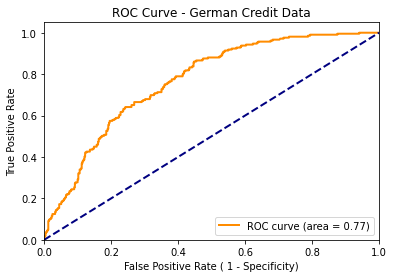

In [61]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate ( 1 - Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc = 'lower right')
plt.show()

In [64]:
# 그리드 검색 => 최적의 임계값 커트라인을 결정
for i in list(np.arange(0.0, 1.0, 0.1)):
    both['y_pred'] = 0
    both.loc[both['probs'] > i, 'y_pred'] = 1
    print("Threshold", i, "Train Accuracy:", round(accuracy_score(both['class'], both['y_pred']),4))


Threshold 0.0 Train Accuracy: 0.2986
Threshold 0.1 Train Accuracy: 0.4786
Threshold 0.2 Train Accuracy: 0.6157
Threshold 0.30000000000000004 Train Accuracy: 0.6771
Threshold 0.4 Train Accuracy: 0.7286
Threshold 0.5 Train Accuracy: 0.74
Threshold 0.6000000000000001 Train Accuracy: 0.7171
Threshold 0.7000000000000001 Train Accuracy: 0.7143
Threshold 0.8 Train Accuracy: 0.7057
Threshold 0.9 Train Accuracy: 0.7014


In [66]:
# Threshold값 0.5에서 0.74를 기록
# 따라서, 훈련데이터를 분류하기 위한 임계값 0.5로 설정
both['y_pred'] = 0
both.loc[both['probs'] > 0.5 , 'y_pred'] = 1

In [68]:
pd.crosstab(both['class'], both['y_pred'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,430,61
1,121,88


In [70]:
accuracy_score(both['class'], both['y_pred'])

0.74

## Test 데이터에 적용

In [73]:
# 학습된 모델로 테스트 데이터에 적용
y_pred_test = logistic_model.predict(sm.add_constant(x_test.drop(remove_cols, axis = 1))).to_frame()
y_pred_test.columns = ['probs']

In [76]:
# 데이터 프레임 만들기
both_test = pd.concat([y_test, y_pred_test], axis = 1)
both_test['y_pred'] = 0
both_test.loc[both_test['probs'] > 0.5, 'y_pred'] = 1

In [77]:
# confusion matrix 작성
pd.crosstab(both_test['class'], both_test['y_pred'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,185,24
1,58,33


In [79]:
# 정확도 확인
round(accuracy_score(both_test['class'], both_test['y_pred']),4)

0.7267